In [27]:
#import modules
import pandas as pd

#list all csv files only
csv_files = ['Data/tns_search (14).csv', 'Data/tns_search (5).csv', 'Data/tns_search (6).csv', 'Data/tns_search (7).csv', 'Data/tns_search (8).csv', 'Data/tns_search (9).csv']


In [28]:
df_append = pd.DataFrame()

#append all files together
for file in csv_files:
    df_temp = pd.read_csv(file)
    df_append = pd.concat([df_append, df_temp], ignore_index=True)


In [29]:
df_append.to_csv("Data/ZTF_info.csv")

In [240]:
import pandas as pd

info = pd.read_csv("Data/ZTF_info.csv")


In [241]:
from astropy.time import Time

times = Time(list(info["Discovery Date (UT)"]), format = "iso", scale='utc')
times_JD = times.jd
times_JD_start = times_JD - 100
times_JD_end = times_JD + 500

In [242]:
from astropy.coordinates import SkyCoord
from astropy import units as u
ra_dec = SkyCoord(info["RA"].values, info["DEC"].values, unit=(u.hourangle, u.deg))
ra_degree = ra_dec.ra.degree
dec_degree = ra_dec.dec.degree

In [245]:
import numpy as np

nan_names = (info["Disc. Internal Name"].values != "nan")
downloading_info = np.column_stack((info["Disc. Internal Name"].values[nan_names], ra_degree[nan_names], dec_degree[nan_names], times_JD_start[nan_names], times_JD_end[nan_names]))
np.savetxt("ZTF_api/ZTF_info.txt", downloading_info, fmt = "%s")

In [8]:
import os

# Specify the directory where the files are located
directory = "Data/ATLAS_forced_photometry_data/"

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the file matches the pattern "SN xxxx.csv"
    if filename.startswith("SN ") and filename.endswith(".csv"):
        # Create the new filename by replacing the space with an underscore
        new_filename = filename.replace(" ", "_")
        
        # Get the full path of the old and new filenames
        old_file = os.path.join(directory, filename)
        new_file = os.path.join(directory, new_filename)
        
        # Rename the file
        os.rename(old_file, new_file)


In [132]:
import numpy as np

atlas_id = "SN_2022ozx"
atlas_data =  np.loadtxt(f"Data/ATLAS_forced_photometry_data/cleaned_and_stacked/{atlas_id}_atlas_fp_stacked_2_days.txt", delimiter = ",", dtype = str)

In [133]:
time = atlas_data[1:, 0].astype(np.float32)
flux = atlas_data[1:, 1].astype(np.float32)
fluxerr = atlas_data[1:, 2].astype(np.float32)
filter = atlas_data[1:, 3].astype(str)

In [134]:
delete_indices = np.where(fluxerr > 40)

time = np.delete(time, delete_indices)
flux = np.delete(flux, delete_indices)
fluxerr = np.delete(fluxerr, delete_indices)
filter = np.delete(filter, delete_indices)

filter_f1 = np.where(filter == "o")
filter_f2 = np.where(filter == "c")

In [135]:
def find_baseline(time, flux, filter_f1, filter_f2):

    past_and_future_epochs = {"Past Future f1":[], "Past Future f2":[], "First SN epoch f1":[], "Last SN epoch f1":[], "First SN epoch f2":[], "Last SN epoch f2":[]}

    # Past
    for filter_number, filter_idx in enumerate([filter_f1, filter_f2]):

        time_filter, flux_filter = time[filter_idx], flux[filter_idx]

        peak_idx = np.argmax(flux_filter)
        num_to_cut = 0
        
        # Check if there is pre-peak data 
        if peak_idx == 0:
            past_and_future_epochs[f"First SN epoch f{filter_number + 1}"] = filter_idx[0][0]
            continue

        # Slope at which the data is no longer constant
        m_cutoff = 0.1 * np.abs((flux_filter[0] - flux_filter[peak_idx]) / (time_filter[0] - time_filter[peak_idx]))

        #Calculate the slope of all data before the peak
        for cut_idx in range(1, peak_idx):

            m = np.abs((flux_filter[0] - flux_filter[cut_idx]) / (time_filter[0] - time_filter[cut_idx]))

            if m < m_cutoff:
                num_to_cut = cut_idx

        if num_to_cut > 0:
            past_and_future_epochs[f"Past Future f{filter_number + 1}"].extend(filter_idx[0][:(num_to_cut + 1)])
            past_and_future_epochs[f"First SN epoch f{filter_number + 1}"] = filter_idx[0][num_to_cut + 1]

        # There is no pre-supernova data
        else:
            past_and_future_epochs[f"First SN epoch f{filter_number + 1}"] = filter_idx[0][0]

    # Future
    for filter_number, filter_idx in enumerate([filter_f1, filter_f2]):

        time_filter, flux_filter = time[filter_idx], flux[filter_idx]

        peak_idx = np.argmax(flux_filter)
        first_post_peak_idx = len(flux_filter) - np.argmax(flux_filter)
        num_to_cut = 0
        
        # Check if there is post-peak data 
        if peak_idx == len(flux_filter) - 1:
            past_and_future_epochs[f"Last SN epoch f{filter_number + 1}"] = filter_idx[0][len(flux_filter) - 1]
            continue

        # Slope at which the data is no longer constant
        m_cutoff = 0.1 * np.abs((flux_filter[-1] - flux_filter[peak_idx]) / (time_filter[-1] - time_filter[peak_idx]))

        #Calculate the slope of all data before the peak
        for idx in range(2, first_post_peak_idx):
            
            cut_idx = -1 * idx
            m = np.abs((flux_filter[-1] - flux_filter[cut_idx]) / (time_filter[-1] - time_filter[cut_idx]))

            if m < m_cutoff:
                num_to_cut = idx

        if num_to_cut > 0:
            past_and_future_epochs[f"Past Future f{filter_number + 1}"].extend(filter_idx[0][-num_to_cut:])
            past_and_future_epochs[f"Last SN epoch f{filter_number + 1}"] = filter_idx[0][-num_to_cut - 1]

        # There is no post-supernova data
        else:
            past_and_future_epochs[f"Last SN epoch f{filter_number + 1}"] = filter_idx[0][len(flux_filter) - 1]
    
    return past_and_future_epochs

In [136]:
past_and_future = find_baseline(time, flux, filter_f1, filter_f2)

In [137]:
def subtract_baseline(flux, filter_f1, filter_f2, past_and_future_epochs):

    if len(past_and_future_epochs["Past Future f1"]) != 0:

        average_flux_baseline_f1 = np.mean(flux[past_and_future_epochs["Past Future f1"]])

        flux[filter_f1] -= average_flux_baseline_f1

    if len(past_and_future_epochs["Past Future f2"]) != 0:

        average_flux_baseline_f2 = np.mean(flux[past_and_future_epochs["Past Future f2"]])

        flux[filter_f2] -= average_flux_baseline_f2

    return flux

In [138]:
flux = subtract_baseline(flux, filter_f1, filter_f2, past_and_future)

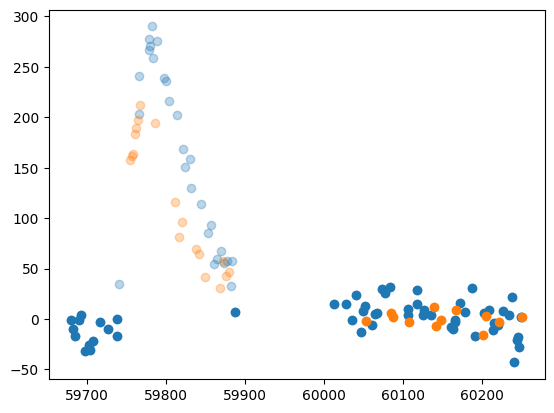

In [139]:
import matplotlib.pyplot as plt

plt.scatter(time[filter_f1], flux[filter_f1], c = "tab:blue", alpha = 0.3)
plt.scatter(time[filter_f2], flux[filter_f2], c = "tab:orange", alpha = 0.3)

plt.scatter(time[past_and_future["Past Future f1"]], flux[past_and_future["Past Future f1"]], c = "tab:blue")
plt.scatter(time[past_and_future["Past Future f2"]], flux[past_and_future["Past Future f2"]], c = "tab:orange")

plt.show()

In [223]:
import numpy as np

# ztf_data =  np.load("forcedphotometry_req00387499_lc.txt")

with open("forcedphotometry_req00387499_lc.txt") as f:
    lines = (line for line in f if not line.startswith('#'))
    ztf_data = np.genfromtxt(lines, skip_header = 1, missing_values = "null", dtype = "str")


In [224]:
time = np.array(ztf_data[:, 22])
differential_flux = np.array(ztf_data[:, 24])
differential_fluxerr = np.array(ztf_data[:, 25])
zero_point = np.array(ztf_data[:, 20])
reduced_chi_squared = np.array(ztf_data[:, 27])
filter = np.array(ztf_data[:, 4])

infobitssci = np.array(ztf_data[:, 6]).astype(np.float32)
scisigpix = np.array(ztf_data[:, 9]).astype(np.float32)
sciinpseeing = np.array(ztf_data[:, 7]).astype(np.float32)

missing_data = np.where(differential_flux == "null")[0]
bad_infobitssci = np.where(infobitssci > 0)[0]
bad_scisigpix = np.where(scisigpix > 25)[0]
bad_sciinpseeing = np.where(sciinpseeing > 4)[0]

indices_to_delete = np.sort(np.unique(np.concatenate((missing_data, bad_infobitssci, bad_scisigpix, bad_sciinpseeing))))

time = np.delete(time, indices_to_delete).astype(np.float32) -  2400000.5
differential_flux = np.delete(differential_flux, indices_to_delete).astype(np.float32) / 10
differential_fluxerr = np.delete(differential_fluxerr, indices_to_delete).astype(np.float32) / 10
zero_point = np.delete(zero_point, indices_to_delete).astype(np.float32)
reduced_chi_squared = np.delete(reduced_chi_squared, indices_to_delete).astype(np.float32)
filter = np.delete(filter, indices_to_delete)

filter_f1 = np.where(filter == "ZTF_r")
filter_f2 = np.where(filter == "ZTF_g")

In [225]:
past_and_future = find_baseline(time, differential_flux, filter_f1, filter_f2)
differential_flux = subtract_baseline(differential_flux, filter_f1, filter_f2, past_and_future)

In [226]:
def check_flux_uncertainties(fluxerr, reduced_chi_squared):

    average_reduced_chi_squared = np.mean(reduced_chi_squared)

    if not np.isclose(average_reduced_chi_squared, 1, 0.5):

        fluxerr *= np.sqrt(average_reduced_chi_squared)

    return fluxerr

In [227]:
differential_fluxerr = check_flux_uncertainties(differential_fluxerr, reduced_chi_squared)

In [228]:
def ztf_flux_to_magnitude(flux, fluxerr, zero_point):

    mag = np.empty(len(flux))
    magerr = np.empty(len(flux))

    confident_detections = differential_flux/differential_fluxerr > 3

    mag[confident_detections] = zero_point[confident_detections] - 2.5 * np.log10(10 * flux[confident_detections])
    magerr[confident_detections] = 1.0857 * fluxerr[confident_detections] / flux[confident_detections]

    mag[~confident_detections] = zero_point[~confident_detections] - 2.5 * np.log10(10 * 5 * fluxerr[~confident_detections])
    magerr[~confident_detections] = 0

    return mag, magerr

In [229]:
mag, magerr = ztf_flux_to_magnitude(differential_flux, differential_fluxerr, zero_point)

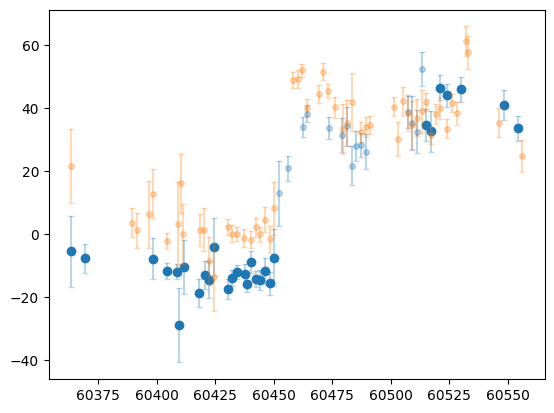

In [230]:
import matplotlib.pyplot as plt

plt.errorbar(time[filter_f1], differential_flux[filter_f1], differential_fluxerr[filter_f1], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", alpha = 0.3)
plt.errorbar(time[filter_f2], differential_flux[filter_f2], differential_fluxerr[filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange", alpha = 0.3)

plt.scatter(time[past_and_future["Past Future f1"]], differential_flux[past_and_future["Past Future f1"]], c = "tab:blue")
plt.scatter(time[past_and_future["Past Future f2"]], differential_flux[past_and_future["Past Future f2"]], c = "tab:orange")

plt.show()

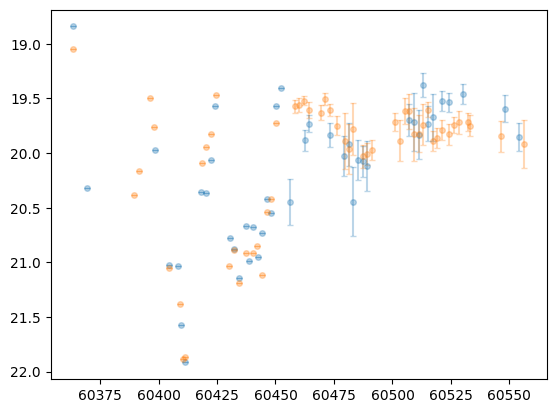

In [231]:
plt.errorbar(time[filter_f1], mag[filter_f1], magerr[filter_f1], fmt = "o", markersize = 4, capsize = 2, color = "tab:blue", alpha = 0.3)
plt.errorbar(time[filter_f2], mag[filter_f2], magerr[filter_f2], fmt = "o", markersize = 4, capsize = 2, color = "tab:orange", alpha = 0.3)

plt.gca().invert_yaxis()

plt.show()